In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

A version of resampling employing SimpleITK resampling function

NOTATION: With the variable name {smth}_nda I mean the numpy ndarray corresponding to a SimpleITK image

In [2]:
#load the segmentation mask using SimpleITK
mhd_path = 'mask001.mhd'   #put the .mhd and .raw files in same directory or your own path to mask001.mhd
img = sitk.ReadImage(mhd_path)

#Retrieve image information
origin = np.array(img.GetOrigin())
size = np.array(img.GetSize())
spacing = np.array(img.GetSpacing())
physical_ext = size*spacing
print('origin', origin)
print('size', size)
print('spacing', spacing)
print('extension', physical_ext)

origin [0. 0. 0.]
size [1024 1024  200]
spacing [0.41362 0.41362 1.4506 ]
extension [423.54688 423.54688 290.12   ]


In [3]:
# plots the slice at the middle for each axis
# img should be a numpy array
def plot_middle_slices(img):
    print(img.shape)
    fig = plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(img[img.shape[0]//2,:,:])
    plt.subplot(1,3,2)
    plt.imshow(img[:,img.shape[1]//2,:])
    plt.subplot(1,3,3)
    plt.imshow(img[:,:,img.shape[2]//2])

In [4]:
#Function based on SITK resample, that resamples img to new_spacing and new_size
def resample_sitk(img, new_size, new_spacing):
    resampleFilter = sitk.ResampleImageFilter()
    res_img = resampleFilter.Execute(img, new_size, sitk.Transform(), 
                                     sitk.sitkNearestNeighbor, img.GetOrigin(),
                                     new_spacing, img.GetDirection(), 0, img.GetPixelID())
    return res_img

In [5]:
#We want to resample to isotropic and spacing 1 mm in all directions
new_spacing = [1,1,1]
new_size = [int(round(physical_ext[0])),
            int(round(physical_ext[1])),
            int(round(physical_ext[2]))]

iso_img = resample_sitk(img, new_size=new_size, new_spacing=new_spacing)
print(iso_img.GetSpacing())
print(iso_img.GetSize())

(1.0, 1.0, 1.0)
(424, 424, 290)


(200, 1024, 1024)
(290, 424, 424)


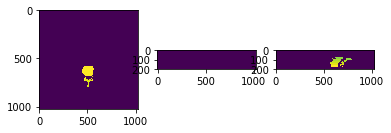

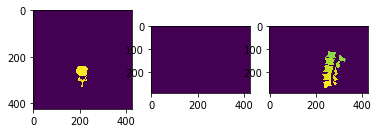

In [6]:
#Show middle slices in each direction to show how the resampling worked
orig_nda = sitk.GetArrayViewFromImage(img)
iso_nda  = sitk.GetArrayViewFromImage(iso_img)

plot_middle_slices(orig_nda)
plot_middle_slices(iso_nda)

In [7]:
#keep only the volume containing the mask (=where the image has non zero values)
nnz_idx = np.where(iso_nda>0)
#NB: the axis order of the image are reversed in the array  (x,y,z) -> (z,y,x)
min_z, max_z = min(nnz_idx[0]), max(nnz_idx[0])
min_y, max_y = min(nnz_idx[1]), max(nnz_idx[1])
min_x, max_x = min(nnz_idx[2]), max(nnz_idx[2])

cut_mask = iso_img[min_x:max_x,min_y:max_y,min_z:max_z]

(156, 98, 98)


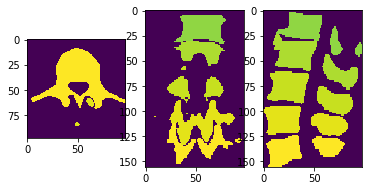

In [8]:
#show middle slices of the box
cut_nda = sitk.GetArrayViewFromImage(cut_mask)
plot_middle_slices(cut_nda)

In [9]:
#Function that crop out an individual vertebra given its segmentation value
def crop_out_vertebra(img_array, vert_value, pad=5):
    z,y,x = np.where(cut_nda==vert_value)
    mz,my,mx = img_array.shape
    mz -= 1; my -= 1; mx -= 1
    min_z, max_z = max(0,min(z)-pad), min(mz,max(z)+pad)
    min_y, max_y = max(0,min(y)-pad), min(my,max(y)+pad)
    min_x, max_x = max(0,min(x)-pad), min(mx,max(x)+pad)
    new_img = np.zeros_like(img_array)
    new_img[z[:],y[:],x[:]] = vert_value
    return new_img[min_z:max_z,min_y:max_y,min_x:max_x]

In [10]:
#Cut out each individual vertebra
vert_values = np.unique(cut_nda)
print('values', vert_values)
vert_volumes = list()
for val in vert_values:
    if val==0: continue
    vert_volumes.append(crop_out_vertebra(cut_nda, vert_value = val))

values [  0 200 210 220 230 240]


(55, 89, 82)
(67, 95, 90)
(64, 93, 97)
(56, 89, 94)
(52, 85, 97)


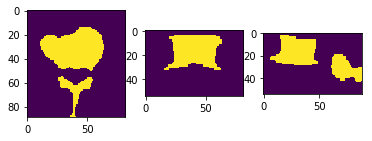

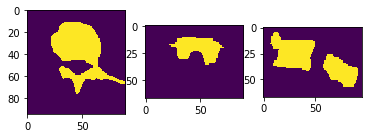

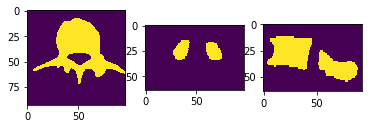

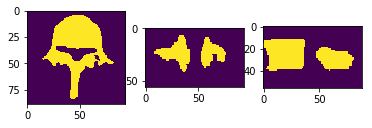

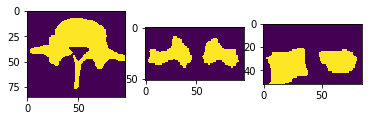

In [11]:
for vol in vert_volumes:
    plot_middle_slices(vol)

In [12]:
#Resize to 64x64x64
from skimage.transform import resize

resized = list()
for vol in vert_volumes:
    box = resize(vol, [64,64,64], mode='constant', cval=0, clip=True, preserve_range=True, anti_aliasing=True)
    resized.append(box)

#TODO: check for better resize paramaters

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


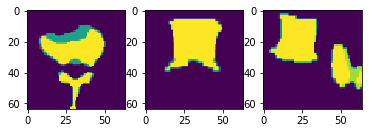

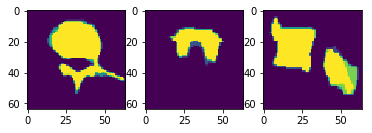

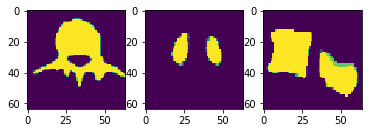

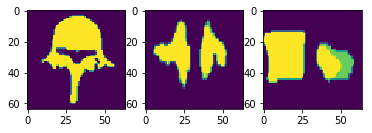

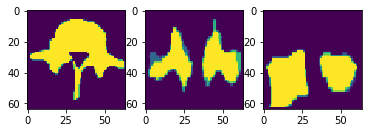

In [13]:
for vol in resized:
    plot_middle_slices(vol)